#Section 1: building the model

In [0]:
#importing the needed libraries:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import pystan

In [0]:
data = pd.read_csv('https://raw.githubusercontent.com/MoGaber/CS146-LBA-data/master/LBA_data_3.csv')

**Normalization step**: Changing all the amounts to 1 unit(kg, liter..etc) and adjusting the prices accordingly(price/amount):

In [3]:
prices_normalized_data = data.copy()

for i in range(5, len(data.columns),2):
    prices_normalized_data.iloc[:,i+1] =  prices_normalized_data.iloc[:,i+1] /prices_normalized_data.iloc[:,i]
    prices_normalized_data.iloc[:,i] =1 
prices_normalized_data.head()

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


,Timestamp,Email Address,Your name,Grocery store,Grocery store street address,Apples_Product 1 quantity (kg),Apples_Product 1 price (€),Apples_Product 2 quantity (kg),Apples_Product 2 price (€),Apples_Product 3 quantity (kg),Apples_Product 3 price (€),Bananas_Product 1 quantity (kg),Bananas_Product 1 price (€),Bananas_Product 2 quantity (kg),Bananas_Product 2 price (€),Bananas_Product 3 quantity (kg),Bananas_Product 3 price (€),Tomatoes_Product 1 quantity (kg),Tomatoes_Product 1 price (€),Tomatoes_Product 2 quantity (kg),Tomatoes_Product 2 price (€),Tomatoes_Product 3 quantity (kg),Tomatoes_Product 3 price (€),Potatoes_Product 1 quantity (kg),Potatoes_Product 1 price (€),Potatoes_Product 2 quantity (kg),Potatoes_Product 2 price (€),Potatoes_Product 3 quantity (kg),Potatoes_Product 3 price (€),"Flour, white_Product 1 quantity (kg)","Flour, white_Product 1 price (€)","Flour, white_Product 2 quantity (kg)","Flour, white_Product 2 price (€)","Flour, white_Product 3 quantity (kg)","Flour, white_Product 3 price (€)","Rice, basmati_Product 1 quantity (kg)","Rice, basmati_Product 1 price (€)","Rice, basmati_Product 2 quantity (kg)","Rice, basmati_Product 2 price (€)","Rice, basmati_Product 3 quantity (kg)","Rice, basmati_Product 3 price (€)","Milk, full cream_Product 1 quantity (liters)","Milk, full cream_Product 1 price (€)","Milk, full cream_Product 2 quantity (liters)","Milk, full cream_Product 2 price (€)","Milk, full cream_Product 3 quantity (liters)","Milk, full cream_Product 3 price (€)",Butter_Product 1 quantity (kg),Butter_Product 1 price (€),Butter_Product 2 quantity (kg),Butter_Product 2 price (€),Butter_Product 3 quantity (kg),Butter_Product 3 price (€),Eggs_Product 1 quantity (count),Eggs_Product 1 price (€),Eggs_Product 2 quantity (count),Eggs_Product 2 price (€),Eggs_Product 3 quantity (count),Eggs_Product 3 price (€),Chicken breasts_Product 1 quantity (kg),Chicken breasts_Product 1 price (€),Chicken breasts_Product 2 quantity (kg),Chicken breasts_Product 2 price (€),Chicken breasts_Product 3 quantity (kg),Chicken breasts_Product 3 price (€)
0,10/28/2019 13:14:59,brian.swanberg@minerva.kgi.edu,Brian Swanberg,ALDI,Rummelsburger Str. 98,1,2.500000,1,1.880000,1,3.1500,1,1.69,1,0.99,1,NaN,1,3.523077,1,2.98,1,1.890000,1,0.556000,1,0.498000,1,1.245000,1,0.39,1,NaN,1,NaN,1,1.99,1,NaN,1,NaN,1,0.99,1,3.150000,1,0.99,1,5.56,1,6.36,1,9.56,1,0.119000,1,0.265000,1,0.159000,1,6.65000,1,5.990,1,NaN
1,10/29/2019 14:19:19,emma.stiefel@minerva.kgi.edu,Emma Stiefel,REWE,Karl-Marx-Straße 92-98,1,2.490000,1,1.490000,1,2.4900,1,0.99,1,1.69,1,1.590,1,6.900000,1,4.58,1,5.685714,1,0.563333,1,2.490000,1,1.526667,1,0.39,1,1.38,1,0.79,1,7.16,1,3.98,1,10.375,1,1.29,1,1.390000,1,0.79,1,5.56,1,5.56,1,9.56,1,0.281667,1,0.250000,1,0.265000,1,13.90000,1,9.990,1,9.980000
2,10/29/2019 21:22:30,taha@minerva.kgi.edu,Taha,ALDI,"Hermannstraße 72, 12049 Berlin, Germany",1,2.990000,1,1.790000,1,2.3625,1,1.15,1,1.69,1,1.495,1,3.580000,1,1.99,1,4.580000,1,0.556000,1,1.325000,1,0.798000,1,0.39,1,1.49,1,1.39,1,3.98,1,NaN,1,NaN,1,1.05,1,0.710000,1,0.99,1,9.56,1,5.16,1,5.16,1,0.159000,1,0.119000,1,0.265000,1,6.65000,1,5.990,1,11.400000
3,10/30/2019 16:20:11,michaelchen@minerva.kgi.edu,Michael Hao Chen,Lidl,"Lidl, Leipziger Str. 42",1,1.790000,1,2.653333,1,2.3625,1,1.09,1,1.69,1,1.190,1,7.114286,1,1.89,1,3.580000,1,0.750000,1,0.556000,1,NaN,1,0.39,1,0.89,1,NaN,1,2.98,1,6.36,1,1.990,1,1.05,1,1.290000,1,1.15,1,9.56,1,6.36,1,6.76,1,0.119000,1,0.169000,1,0.265000,1,6.65000,1,6.975,1,NaN
4,10/30/2019 16:24:57,michaelchen@minerva.kgi.edu,Michael Hao Chen,REWE,"REWE, Landsberger Allee 68D",1,3.830769,1,2.190000,1,1.4900,1,0.99,1,1.89,1,1.590,1,1.990000,1,3.98,1,4.580000,1,0.563333,1,1.526667,1,1.490000,1,0.79,1,0.39,1,0.79,1,5.58,1,1.99,1,9.980,1,1.90,1,0.763636,1,0.71,1,7.96,1,5.56,1,9.56,1,0.331667,1,0.381667,1,0.165833,1,13.02439,1,10.000,1,29.894737


Loading the data of the locations so that I can see which shop belongs to which area:


In [0]:
area_data = pd.read_csv('https://raw.githubusercontent.com/MoGaber/CS146-LBA-data/master/area_data.csv')
area_data = area_data.drop(columns = ['GPS'])
area_data = area_data.dropna()

In [0]:
area_details = [area_data['Supermarket'], area_data['Neighborhood']]
location_dict = {}
for i in range(len(area_details[0])):
    s = area_details[0][i].split(',')[-1]
    s = s[1:]
    location_dict[s] = area_details[1][i]

In [0]:
#defining this function to match the adress in the products data with that in the area data
def inn(a, c=location_dict):
    b=a.split(',')
    for i in b:
        if i[0]==' ':
            i = i[1:]
        if i in location_dict.keys():
            return(i)
    return False    

Geographical_Location = []
for i in prices_normalized_data['Grocery store street address']:
    
    if inn(i):
            Geographical_Location.append(location_dict[inn(i)])
    else:
            Geographical_Location.append(i)

In [0]:
prices_normalized_data['Geographical Location'] = Geographical_Location #adding a new column to the dataset for locations


The dataset had three columns for each product, since the dataset didn't clearly mention that they are different, I assume that the three columns are for the same product and I combine them in one column below:

In [0]:
products_data = []
j = 6
for i in range(10):
    products_data.append(pd.concat([prices_normalized_data[prices_normalized_data.columns[j]], 
                                    prices_normalized_data[prices_normalized_data.columns[j+2]], 
                                    prices_normalized_data[prices_normalized_data.columns[j+4]] ], ignore_index=True))
    j+=6
    
#Doing the same for the brands and the locations. Since one row(of three columns has the same brand and location,
#I'm addin three columns together so they can match with the columns above.)

Brands = [pd.concat([prices_normalized_data['Grocery store'], 
                                    prices_normalized_data['Grocery store'], 
                                    prices_normalized_data['Grocery store']], ignore_index=True)][0]

Locations = [pd.concat([prices_normalized_data['Geographical Location'], 
                                    prices_normalized_data['Geographical Location'], 
                                    prices_normalized_data['Geographical Location']], ignore_index=True)][0]

In [0]:
#Prices for each product:
Apples_data= products_data[0]
Bananas_data = products_data[1]
Tomatoes_data = products_data[2]
Potatoes_data = products_data[3]
Flour_white_data = products_data[4]
Rice_basmati_data = products_data[5]
Milk_full_cream_data = products_data[6]
Butter_data = products_data[7]
Eggs_data = products_data[8]
Chicken_breasts_data = products_data[9]

In [0]:
#Building a final dataframe for my model:
Model_dataframe = pd.DataFrame({'Brands': Brands, "Locations": Locations,
                               'Apples':Apples_data, 'Bananas':Bananas_data,
                               'Tomatoes':Tomatoes_data, 'Potatoes':Potatoes_data
                               ,'Flour_white':Flour_white_data, 'Rice_basmati':Rice_basmati_data
                               ,'Milk_full_cream':Milk_full_cream_data, 'Butter':Butter_data,
                               'Eggs':Eggs_data, 'Chicken_breasts':Chicken_breasts_data})



Since this dataset will go through Stan, I need to change strings to numbers:


In [0]:
Model_dataframe['Brands'] = Model_dataframe['Brands'].replace(['ALDI', 'REWE', 'Lidl', 'Tesco Express', 'EDEKA',
                                  'Waitrose & Partners', 'Safeway', 'Tesco', "Sainsbury's"],
                                  [ 1, 2, 3, 4, 5, 6, 7, 8, 9])

Model_dataframe['Locations'] = Model_dataframe['Locations'].replace(['Lichtenberg', 'Neukölln', 'Mitte', 'Friedrichshain',
       'Farringdon, London', 'Islington, London', 'Briton Ferry, London',
       'Edgware, London', 'Cazenove, London', 'San Francisco, CA',
       'Kreuzberg', 'Mountain View, CA', 'Palo Alto, CA',
       'Prenzlauer Berg', 'Barbican, London', 'Alt-Treptow',
       'Fitzrovia, London', 'The Brunswick Centre, London',
       'The Angel, London', 'Schöneberg', 'Crouch End, London',
       'Shoreditch, London', 'Tempelhof', 'New Kent, London',
       'Le Grand, London', 'Mayfair, London', 'Temple, London'],
                                  [i for i in range(1, 28)])

In [12]:
Model_dataframe = Model_dataframe.dropna() #removing the NAs from my dataset before building my model:
Model_dataframe.head() #printing some of the data

,Brands,Locations,Apples,Bananas,Tomatoes,Potatoes,Flour_white,Rice_basmati,Milk_full_cream,Butter,Eggs,Chicken_breasts
0,1,1,2.500000,1.69,3.523077,0.556000,0.39,1.99,0.99,5.56,0.119000,6.65000
1,2,2,2.490000,0.99,6.900000,0.563333,0.39,7.16,1.29,5.56,0.281667,13.90000
2,1,2,2.990000,1.15,3.580000,0.556000,0.39,3.98,1.05,9.56,0.159000,6.65000
3,3,3,1.790000,1.09,7.114286,0.750000,0.39,2.98,1.05,9.56,0.119000,6.65000
4,2,4,3.830769,0.99,1.990000,0.563333,0.79,5.58,1.90,7.96,0.331667,13.02439


**Assumptions:**

After I have cleaned my dataset and prepared it as shown above, I can now start building the model. My model should at least have the following parameters:
- Base Price 
  - The currency that was mentioned in the given dataset was Euro so I'm assuming that the currency for base price is Euro over all locations. Since we need a broad prior for it, then I belive Cauchy distribution is a good choice since it's a heavy-tailed distribution which makes it a broad prior distribution. Examining the data, I see that most of the prices of the products vary between 0.5 and 8 Euros so I will center the cauchy distribution at 4 with a scale parameter of 5 to have a broad distriubtion.
- The multiplier for each store brand
  - Since we don't have much information about the multipliers, then I will also choose cauchy distribution that will be centered on 1 to achieve an average multiplier of 1 and with the scale parameter at .5 for some variance
- The multiplier for the geographical location
  * Will use the same distribution as the brand multiplier
- Finally, I will choose a normal distribution as the likelihood function so that I can consider the given equation (base price * brand multiplier * geographical multiplier which are all obtained from cauchy distributions) as the mean of the distribution and then since we need random noise, I will choose the cauchy distribution again centerd at 0 with variance 0.5 to model sigma of the normal distribution and achive that small random noise required.



*Note that since Cauchy's support includes negative numbers, then we set the lower bound of the paramters to 0 to make sure that our parameters are positive.*

*Note that I'm going to use three different cities: Berlin, London, California. Since the prices were reported in Euro as given in the dataset, then I'm considering this as the currency in my model. I found one observation from Seoul but I deleted it since it's only one point and might act as an outlier in my model.*

*Note, in my conclusions below, I will assume that the means of the various distributions can be generalized to represent their paramters (the prices and the multipliers effects)*


In [0]:
stan_code = """


data {
    int<lower=0> N_products; // Number of the products which should be 10
    int<lower=0> N_product_observations; // Total number of observations for each product

    int<lower=0> N_locations; // Number of locations given to us
    int<lower=0> N_brands; // Number of brands given to us

    real<lower=0>  prices[N_products, N_product_observations]; // This will be a list of lists containg the prices for each product
    int  brands[N_product_observations]; // list of brands for each observation
    int  locations[N_product_observations]; //list of location for each observation


    
}


parameters {
    real<lower=0>  base_prices[N_products]; // we should have 10 base prices
    real<lower=0>  brand_multiplier[N_brands]; 
    real<lower=0>  location_multiplier[N_locations];
    real<lower=0>  sigma;

    
}


model {
    for (i in 1:N_products){
    base_prices[i] ~ cauchy(4, 5); // a braod prior for base price
    };

    for (i in 1:N_brands){
    brand_multiplier[i] ~ cauchy(1, .5); // 
    };

    for (i in 1:N_locations){
    location_multiplier[i] ~ cauchy(1, .5); // 
    };

    sigma ~ cauchy(0, .5);

    for (i in 1:N_products){ // The normal likelihood function running over all the observation of each product
      for (j in 1:N_product_observations){
        prices[i, j] ~ normal(base_prices[i]* brand_multiplier[brands[j]]*location_multiplier[locations[j]], sigma);
      }
    } 
    
    
    
}

"""

In [14]:
stan_model = pystan.StanModel(model_code=stan_code) #Compiling the stan code that we wrote above.

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cae3f7055362b3a6529cdf63abe16166 NOW.


In [0]:
#making the list of lists that contain the prices of each product
prices = [Model_dataframe['Apples'], Model_dataframe['Bananas'], Model_dataframe['Tomatoes'],
          Model_dataframe['Potatoes'], Model_dataframe['Flour_white'], Model_dataframe['Rice_basmati'],
          Model_dataframe['Milk_full_cream'], Model_dataframe['Butter'], Model_dataframe['Eggs'],
          Model_dataframe['Chicken_breasts']]

#passing the data to the stan model above
stan_data = {
    'N_products': 10,
    'N_product_observations': len(Model_dataframe),
    'N_locations': len(Model_dataframe["Locations"].unique()),
    'N_brands': len(Model_dataframe["Brands"].unique()),
    'prices': prices,
    'brands':  Model_dataframe['Brands'],
    'locations': Model_dataframe['Locations']}


results_task = stan_model.sampling(data=stan_data)

#Stan Model Results:

In [16]:
print(results_task)

Inference for Stan model: anon_model_cae3f7055362b3a6529cdf63abe16166.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
base_prices[1]            2.82    0.02   0.49   1.96   2.47   2.77    3.1   3.94    825   1.01
base_prices[2]            2.16    0.01   0.41   1.48   1.87   2.13   2.41   3.06    959   1.01
base_prices[3]            4.34    0.03   0.71   3.13   3.85   4.28   4.74   5.98    786   1.01
base_prices[4]            1.41  8.8e-3    0.3    0.9    1.2   1.38    1.6   2.08   1177   1.01
base_prices[5]             1.2  7.5e-3   0.28    0.7    1.0   1.17   1.37   1.82   1424    1.0
base_prices[6]            3.48    0.02   0.59   2.48   3.08   3.44   3.84   4.81    796   1.01
base_prices[7]            1.02  6.9e-3   0.27   0.56   0.83    1.0   1.18   1.61   1543    1.0
base_prices[8]            7.08    0.04   1.13   5.1

#Section 2: Questions to answer



In [0]:
#Getting samples for all the vairables from the model:
Stan_Samples = results_task.extract()

#Basic Price Averages

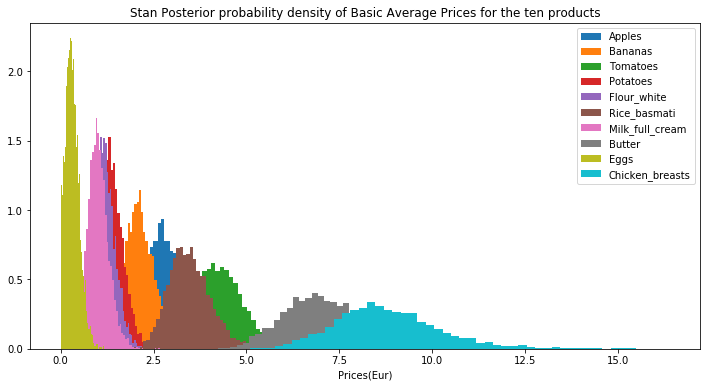

,Product,Mean,95% Confidence Interval
0,Apples,2.815190,"[1.966812318479954, 3.9372703788190924]"
1,Bananas,2.163076,"[1.4819484846312845, 3.0604898196343786]"
2,Tomatoes,4.342209,"[3.1280312701059376, 5.984002157745427]"
3,Potatoes,1.410638,"[0.9015826248393134, 2.0806814822058732]"
4,Flour_white,1.195842,"[0.7063042595436475, 1.8222988204219805]"
5,Rice_basmati,3.484402,"[2.4842686540721672, 4.807300819672604]"
6,Milk_full_cream,1.021504,"[0.5594022433885373, 1.6117695154307754]"
7,Butter,7.079399,"[5.17378977796435, 9.657705395150632]"
8,Eggs,0.316996,"[0.028366959007570337, 0.7192729387456702]"
9,Chicken_breasts,8.804495,"[6.407578034062855, 12.06287258466743]"


In [18]:
plt.figure(figsize=(12, 6))
products = Model_dataframe.columns[2:]#name of the products
means =[]
confidence_intervals=[]
for i in range(10): #calculating the means and the confidence intervals for the base prices:
  product_samples =Stan_Samples['base_prices'][:,i]
  means.append(np.mean(product_samples))
  confidence_intervals.append(np.percentile(product_samples,[2.5, 97.5]))
  plt.hist(product_samples, label = products[i], density = True, bins = 50 )

plt.legend()
plt.title("Stan Posterior probability density of Basic Average Prices for the ten products")
plt.xlabel("Prices(Eur)")
plt.show()
products_table = pd.DataFrame({"Product": products, "Mean":means, "95% Confidence Interval":confidence_intervals }, index=None)

products_table

#Brand Multipliers

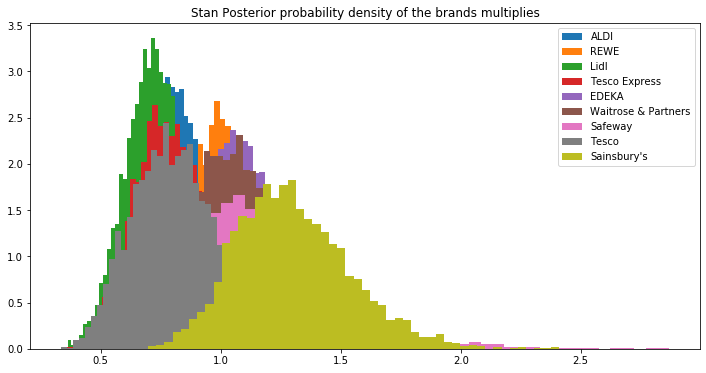

,Brand,Mean,95% Confidence Interval
0,ALDI,0.798049,"[0.5402794792052867, 1.0867598649320278]"
1,REWE,1.017574,"[0.6933021313496005, 1.3731163653132088]"
2,Lidl,0.727657,"[0.4882222727658562, 1.000352236723415]"
3,Tesco Express,0.803032,"[0.5093359785031164, 1.160239975382921]"
4,EDEKA,1.072747,"[0.7338732926404801, 1.458662699777407]"
5,Waitrose & Partners,1.064074,"[0.7380980277994129, 1.4710893555674227]"
6,Safeway,1.169931,"[0.6924274814048771, 1.8620258525449453]"
7,Tesco,0.806108,"[0.4929090936286227, 1.189673942114386]"
8,Sainsbury's,1.301612,"[0.8903822178086737, 1.824649104156505]"


In [19]:
#calculating the means and the confidence intervals for the brand multipliers:
plt.figure(figsize=(12, 6))
brands = ['ALDI', 'REWE', 'Lidl', 'Tesco Express', 'EDEKA','Waitrose & Partners', 'Safeway', 'Tesco', "Sainsbury's"]
means =[]
confidence_intervals=[]
for i in range(len(brands)):
  product_samples =Stan_Samples['brand_multiplier'][:, i]
  means.append(np.mean(product_samples))
  confidence_intervals.append(np.percentile(product_samples,[2.5, 97.5]))
  plt.hist(product_samples, label = brands[i], density = True, bins = 50 )

plt.legend()
plt.title("Stan Posterior probability density of the brands multiplies")
plt.show()
brand_table = pd.DataFrame({"Brand": brands, "Mean":means, "95% Confidence Interval":confidence_intervals }, index=None)

brand_table

We can note that Sainsbury's (which is a brand in London) and Safeway (which is a brand in California) have the highest mean multipliers. We still can't say that this happens because CA and London are more expensive than Berlin because we can also see that the German EDEKA has a higher multiplier than the British Tesco. Which means that these multipliers effects are due to the brand of the store itself.

#Location Multipliers

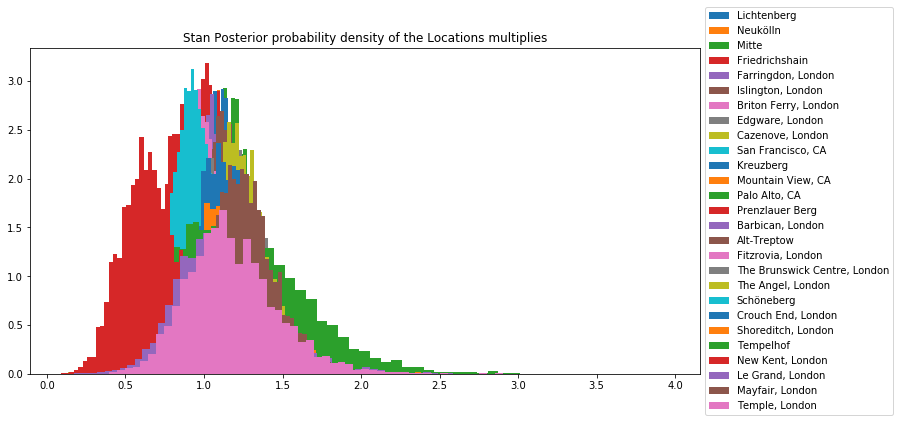

,Location,Mean,95% Confidence Interval
0,Lichtenberg,0.990871,"[0.7308418997445072, 1.3056241441505467]"
1,Neukölln,1.113588,"[0.8488656200749165, 1.42362168214454]"
2,Mitte,1.181853,"[0.9005695122050932, 1.5176449097123832]"
3,Friedrichshain,1.038629,"[0.7899061079239681, 1.335878681289438]"
4,"Farringdon, London",1.133538,"[0.7653927054830033, 1.6006856415300779]"
5,"Islington, London",1.154080,"[0.7510005528736858, 1.6775468009057375]"
6,"Briton Ferry, London",1.043347,"[0.556724408638608, 1.6146248012190636]"
7,"Edgware, London",1.218220,"[0.8870076789857534, 1.6427497374961413]"
8,"Cazenove, London",0.927600,"[0.43398305582826374, 1.477961889181072]"
9,"San Francisco, CA",1.038719,"[0.6331700736825061, 1.5916395137269745]"


In [20]:
#calculating the means and the confidence intervals for the location multipliers:
plt.figure(figsize=(12, 6))
ax = plt.subplot(111)
Locations= ['Lichtenberg', 'Neukölln', 'Mitte', 'Friedrichshain',
            'Farringdon, London', 'Islington, London', 'Briton Ferry, London',
            'Edgware, London', 'Cazenove, London', 'San Francisco, CA',
            'Kreuzberg', 'Mountain View, CA', 'Palo Alto, CA',
            'Prenzlauer Berg', 'Barbican, London', 'Alt-Treptow',
            'Fitzrovia, London', 'The Brunswick Centre, London',
            'The Angel, London', 'Schöneberg', 'Crouch End, London',
            'Shoreditch, London', 'Tempelhof', 'New Kent, London',
            'Le Grand, London', 'Mayfair, London', 'Temple, London']

means =[]
confidence_intervals=[]
for i in range(len(Locations)):
  product_samples =Stan_Samples['location_multiplier'][:, i]
  means.append(np.mean(product_samples))
  confidence_intervals.append(np.percentile(product_samples,[2.5, 97.5]))
  plt.hist(product_samples, label = Locations[i], density = True, bins = 50 )

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Stan Posterior probability density of the Locations multiplies")
plt.show()
locations_table = pd.DataFrame({"Location": Locations, "Mean":means, "95% Confidence Interval":confidence_intervals }, index=None)

locations_table

We can see that overall, London and California have higher location multipliers than Berlin. This actually makes sense since These two cities are known to be very expensive.

#Which is strongest?

In [21]:
print("Maximum mean brand multiplier effect:", max(brand_table['Mean']))
print("Minimum mean brand multiplier effect:", min(brand_table['Mean']))
print("Maximum mean location multiplier effect:", max(locations_table['Mean']))
print("Minimum mean location multiplier effect:", min(locations_table['Mean']))


Maximum mean brand multiplier effect: 1.3016119639255825
Minimum mean brand multiplier effect: 0.7276572750832053
Maximum mean location multiplier effect: 1.4376577570105264
Minimum mean location multiplier effect: 0.6558779611679142


Using all the data, we find that the maximum mean brand multiplier is 1.287 and the minimum is 0.7275 which means that brands can change up or down by 1.287-0.7275 = 0.5595.

On the other hand, the maximum mean location multiplier is 1.46 while the minimum is 0.657 which means that location can change the price up or down by 1.46-0.657 = 0.803

This shows that the location multiplier has a greater influence on prices than brand mulitplier. However, we should keep in mind that this location mutliplier is international(across countries) which means it might be too high as a reflection of the different life standards between Lonon, CA, and Berlin. Also most of the above brands exists in one city but not the others. To make a more meaningful comparisons, we can repeat these calculations in each city:

In [0]:
#I'm ignoring California since it has very few points

Berlin_locations = ['Lichtenberg', 'Neukölln', 'Mitte', 'Friedrichshain'
                    ,'Kreuzberg', 'Prenzlauer Berg' , 'Alt-Treptow',
                    'Schöneberg', 'Tempelhof'  ]

Berlin_brands = ['ALDI', 'REWE', 'Lidl',  'EDEKA']


London_locations = [ 'Farringdon, London', 'Islington, London', 'Briton Ferry, London',
                    'Edgware, London', 'Cazenove, London', 'Barbican, London', 'Fitzrovia, London', 
                    'The Brunswick Centre, London',
                    'The Angel, London', 'Crouch End, London','Shoreditch, London', 'New Kent, London',
                    'Le Grand, London', 'Mayfair, London', 'Temple, London']

London_brands = ['Tesco Express', 'Waitrose & Partners',  'Tesco', "Sainsbury's"]

mean_mult_Berlin_locations = []
mean_mult_Berlin_brands = []

mean_mult_London_locations = []
mean_mult_London_brands = []

for i in Berlin_locations:
  s = locations_table[locations_table['Location']== i]
  mean_mult_Berlin_locations.append(float(s["Mean"]))

for i in Berlin_brands:
  s = brand_table[brand_table['Brand']== i]
  mean_mult_Berlin_brands.append(float(s["Mean"]))


for i in London_locations:
  s = locations_table[locations_table['Location']== i]
  mean_mult_London_locations.append(float(s["Mean"]))

for i in London_brands:
  s = brand_table[brand_table['Brand']== i]
  mean_mult_London_brands.append(float(s["Mean"]))


In [23]:
print("For Berlin:")
print("Maximum mean brand multiplier effect:", max(mean_mult_Berlin_brands))
print("Minimum mean brand multiplier effect:", min(mean_mult_Berlin_brands))
print("Maximum mean location multiplier effect:", max(mean_mult_Berlin_locations))
print("Minimum mean location multiplier effect:", min(mean_mult_Berlin_locations))

print("\nFor London:")
print("Maximum mean brand multiplier effect:", max(mean_mult_London_brands))
print("Minimum mean brand multiplier effect:", min(mean_mult_London_brands))
print("Maximum mean location multiplier effect:", max(mean_mult_London_locations))
print("Minimum mean location multiplier effect:", min(mean_mult_London_locations))


For Berlin:
Maximum mean brand multiplier effect: 1.0727474665613728
Minimum mean brand multiplier effect: 0.7276572750832053
Maximum mean location multiplier effect: 1.18185309763653
Minimum mean location multiplier effect: 0.9040619668468801

For London:
Maximum mean brand multiplier effect: 1.3016119639255825
Minimum mean brand multiplier effect: 0.8030323309432211
Maximum mean location multiplier effect: 1.2494896354692153
Minimum mean location multiplier effect: 0.6558779611679142


Now we can see that for Berlin, the effect of brand multiplier is 0.35 while the effect of location multiplier is 0.27 which means that in Berlin, the brands have stronger influence on prices.

For London, the effect of brands is 0.492 while the effect of location is 0.592 which means that in London the influence of location on prices is larger.

Note that we have been using the mean to make conclusions which is not the best thing to do since that mean varies according to the variance of the distribution and then it's always better to use confindence intervals(Like those we computed in the tables above) for more cetain results

#Correlation with Rental Prices in Berlin

From the given link, I searched the nearest train stations to each location on the map and extracted the rental prices (I got different number of prices for different locations depending on the number of close train stations to them)

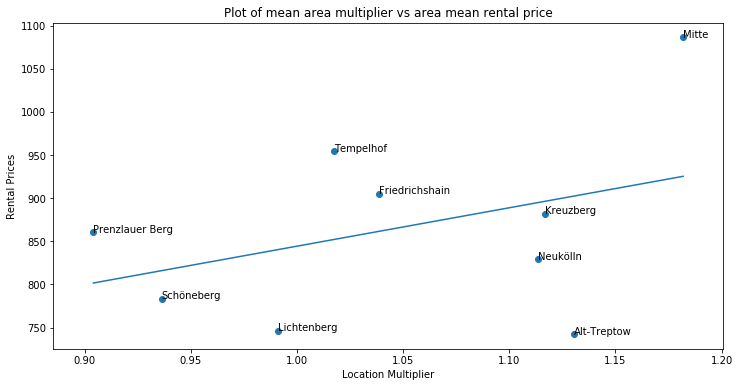

Pearson's Correlation Coeffiecient 0.38395806424343304


In [24]:
Lichtenberg = [752,752, 736]
Neukölln = [812,872,801,833]
Mitte = [1044,1048,1090, 1163]
Friedrichshain = [976,842,942, 860]
Kreuzberg = [865,895,908, 860,]
Prenzlauer_Berg = [856,893, 833]
Alt_Treptow = [743,730, 755]
Schöneberg = [855,797,705,778]
Tempelhof = [957,859,1048]

x= mean_mult_Berlin_locations #location multipliers
y=[]

rental_prices = [Lichtenberg, Neukölln, Mitte, Friedrichshain
                    ,Kreuzberg, Prenzlauer_Berg , Alt_Treptow,
                    Schöneberg, Tempelhof]

for i in rental_prices:
  y.append(np.mean(i)) #taking the mean of the rental prices I found

plt.figure(figsize=(12, 6))
plt.scatter(x, y)
for numb, text in enumerate(Berlin_locations): #plotting area name on the plot
    plt.annotate(text, (x[numb], y[numb]))
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x))) #fitting a best fit line to check the correlation
plt.title('Plot of mean area multiplier vs area mean rental price')
plt.xlabel("Location Multiplier")
plt.ylabel("Rental Prices")
plt.show()
print("Pearson's Correlation Coeffiecient", stats.pearsonr(x, y)[0])

Looking at the graph, we can notice the positive correlation between the mean location multipliers and the mean rental prices around that area with a Pearson's correlation coeffiecient of 0.3895 which is considered relatively strong (or moderate correlation). This can provide the explanation that in Berlin, some areas like Kreuzberg and Mitte are richer than other areas (like Lichtenberg). But it's actually hard to make such generalizations because we can see the outliers (Alt_Treptow that has a high mutliplier but yet one of the lowest rents). So in general, we would need a larger dataset that is more carefully collected (since the data that we used here might be biased in many ways as the collectors were just students trying to complete their assignment).